In [1]:
import pickle
import pandas as pd
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

import pyro
import torch
from pyro.optim import Adam
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv(pm.get_data("radon.csv"))
county_names = df["county"].unique()
num_counties = len(county_names)
print(num_counties)
df[["county", "log_radon", "floor"]].head()

85


,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


### PyMC3

In [3]:
# Individual models
try:
    traces_indiv = pickle.load(open('data/radon.pkl', 'rb'))
        
except FileNotFoundError:
    # Takes about 20 min to fit for all counties
    traces_indiv = {}
    for county_name in county_names:
        c_df = df[df["county"] == county_name]
        x = c_df["floor"].values
        y = c_df["log_radon"].values
        print(f"Sampling for {county_name} ({len(x)} data points)")

        with pm.Model() as individual_model:
            b = pm.Normal('b', mu=0, sd=1)
            w = pm.Normal('w', mu=0, sd=1)
            sigma = pm.HalfCauchy('sigma', beta=1)
            mu = b + w * x
            pm.Normal('y', mu=mu, sd=sigma, observed=y)
            trace = pm.sample(200, tune=200)

        traces_indiv[county_name] = trace
        
    pickle.dump(traces_indiv, open('data/radon.pkl', 'wb'))

In [4]:
# Hierarchical model
x = df["floor"].values
y = df["log_radon"].values
county_idx = df["county_code"].values

with pm.Model() as hierarchical_model:
    b_loc = pm.Normal('b_loc', mu=0, sd=1)
    b_scale = pm.HalfCauchy('b_scale', beta=1)
    w_loc = pm.Normal('w_loc', mu=0, sd=1)
    w_scale = pm.HalfCauchy('w_scale', beta=1)
    
    b = pm.Normal('b', mu=b_loc, sd=b_scale, shape=num_counties)
    w = pm.Normal('w', mu=w_loc, sd=w_scale, shape=num_counties)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = b[county_idx] + w[county_idx] * x
    pm.Normal('y', mu=mu, sd=sigma, observed=y)
    
    trace_hier = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w, b, w_scale, w_loc, b_scale, b_loc]
Sampling 4 chains, 27 divergences: 100%|██████████| 8000/8000 [00:14<00:00, 563.06draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7087620709430716, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


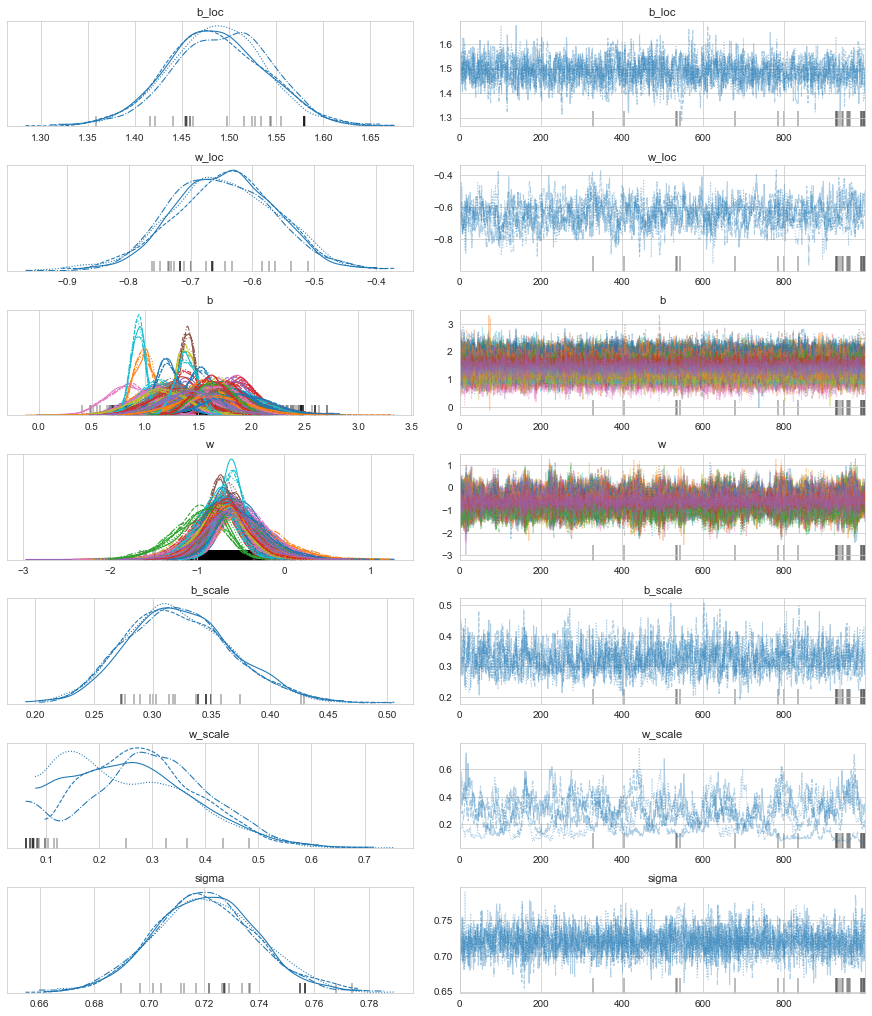

In [5]:
data = az.from_pymc3(trace=trace_hier)
az.plot_trace(data, compact=True);

In [6]:
with pm.Model() as hierarchical_model_reparameterized:
    b_loc = pm.Normal('b_loc', mu=0, sd=1)
    b_scale = pm.HalfCauchy('b_scale', beta=1)
    w_loc = pm.Normal('w_loc', mu=0, sd=1)
    w_scale = pm.HalfCauchy('w_scale', beta=1)
    
    # Reparameterized
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=num_counties)
    w_offset = pm.Normal('w_offset', mu=0, sd=1, shape=num_counties)
    b = pm.Deterministic("b", b_loc + b_offset * b_scale)
    w = pm.Deterministic("w", w_loc + w_offset * w_scale)
    
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = b[county_idx] + w[county_idx] * x
    pm.Normal('y', mu=mu, sd=sigma, observed=y)
    
    trace_hier_reparam = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, w_offset, b_offset, w_scale, w_loc, b_scale, b_loc]
Sampling 4 chains, 2 divergences: 100%|██████████| 8000/8000 [00:15<00:00, 523.75draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7067140468746085, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


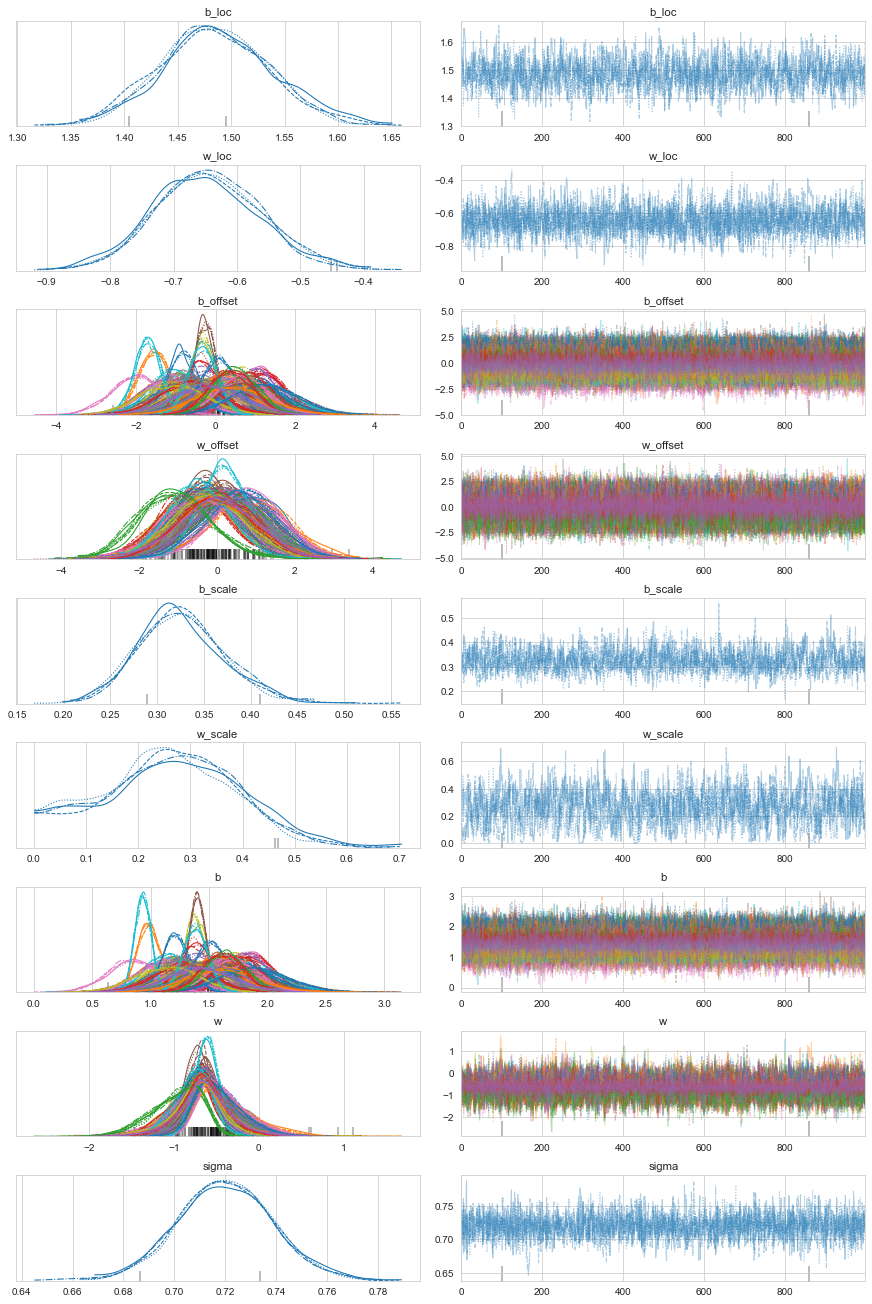

In [7]:
data = az.from_pymc3(trace=trace_hier_reparam)
az.plot_trace(data, compact=True);

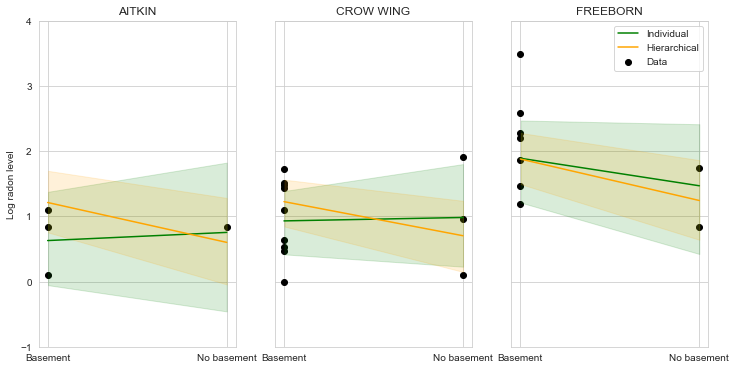

In [8]:
selected_counties = ['AITKIN', 'CROW WING', 'FREEBORN']
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axes[0].set_ylabel('Log radon level')

for i, county_name in enumerate(selected_counties):
    ax = axes[i]
    c_df = df[df["county"] == county_name]
    x = c_df["floor"].values
    y = c_df["log_radon"].values
    county_idx = c_df['county_code'].values[0]
    
    b_indiv = traces_indiv[county_name]['b'].reshape(-1, 1)
    w_indiv = traces_indiv[county_name]['w'].reshape(-1, 1)
    mu_indiv = b_indiv + w_indiv * x
    
    b_hier = trace_hier['b'][:, county_idx].reshape(-1, 1)
    w_hier = trace_hier['w'][:, county_idx].reshape(-1, 1)
    mu_hier = b_hier + w_hier * x
    
    idxs = np.argsort(x)
    x, y, mu_indiv, mu_hier = x[idxs], y[idxs],  mu_indiv[:, idxs], mu_hier[:, idxs]
    
    mean_indiv = mu_indiv.mean(axis=0)
    mean_hier = mu_hier.mean(axis=0)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Basement', 'No basement'])
    ax.set_ylim(-1, 4)
    ax.set_title(county_name)
    ax.scatter(x, y, label='Data', color='black')
    
    ax.plot(x, mean_indiv, color='green', label='Individual')
    az.plot_hpd(x, mu_indiv, color='green', credible_interval=0.95,
                fill_kwargs={'alpha': 0.15}, ax=ax)
    
    ax.plot(x, mean_hier, color='orange', label='Hierarchical')
    az.plot_hpd(x, mu_hier, color='orange', credible_interval=0.95,
                fill_kwargs={'alpha': 0.15}, ax=ax)
    
plt.legend();

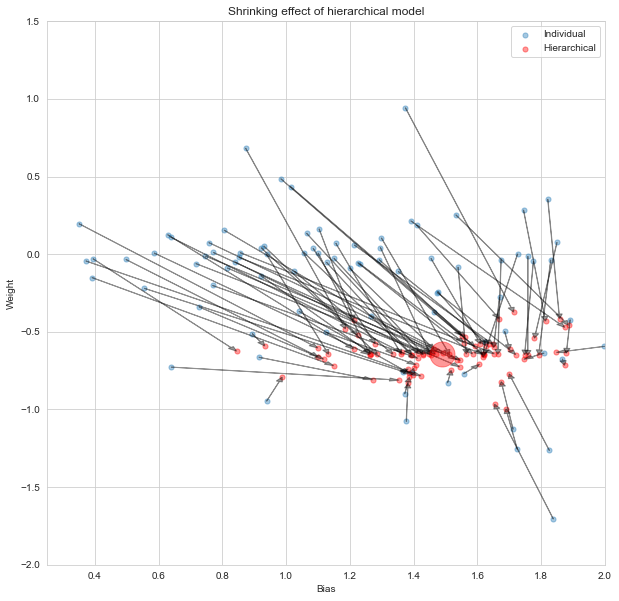

In [9]:
# Visualize shrinking effect of hierarchical model
def plot_shrinking(b_indiv, w_indiv, b_hier, w_hier, b_loc_hier, w_loc_hier):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, xlabel='Bias', ylabel='Weight', xlim=(0.25, 2), ylim=(-2, 1.5))

    ax.set_title("Shrinking effect of hierarchical model")
    ax.scatter(b_indiv, w_indiv, s=26, alpha=0.4, label='Individual')
    ax.scatter(b_hier, w_hier, c='red', s=26, alpha=0.4, label='Hierarchical')
    for i in range(num_counties):  
        ax.arrow(b_indiv[i], w_indiv[i], 
                 b_hier[i] - b_indiv[i], w_hier[i] - w_indiv[i], 
                 fc="k", ec="k", length_includes_head=True, 
                 alpha=0.4, head_width=.02)
    ax.plot(b_loc_hier, w_loc_hier, 
            marker='.', color='red', markersize=50, alpha=0.4)
    ax.legend()
    
b_indiv = [traces_indiv[c]['b'].mean() for c in county_names]
w_indiv = [traces_indiv[c]['w'].mean() for c in county_names]
b_hier = trace_hier['b'].mean(axis=0)
w_hier = trace_hier['w'].mean(axis=0)
b_loc_hier = trace_hier['b_loc'].mean()
w_loc_hier = trace_hier['w_loc'].mean()
plot_shrinking(b_indiv, w_indiv, b_hier, w_hier, b_loc_hier, w_loc_hier)

### Pyro
TODO: custom variational distribution to fix collapsing of w

In [10]:
x = df["floor"].values
y = df["log_radon"].values
county_idx = df["county_code"].values
x, y = [torch.as_tensor(t) for t in (x, y)]

def hierarchical_model(x, county_idx, y, batch_size=len(x)):
    b_loc = pyro.sample("b_loc", dist.Normal(0, 1))
    b_scale = pyro.sample("b_scale", dist.HalfCauchy(1))
    w_loc = pyro.sample("w_loc", dist.Normal(0, 1))
    w_scale = pyro.sample("w_scale", dist.HalfCauchy(1))
    
    with pyro.plate("plate_param", size=num_counties):
        b_offset = pyro.sample("b_offset", dist.Normal(0, 1))
        w_offset = pyro.sample("w_offset", dist.Normal(0, 1))
        b = pyro.deterministic("b", b_loc + b_offset * b_scale)
        w = pyro.deterministic("w", w_loc + w_offset * w_scale)
              
    # Subsample batch
    n = min(len(x), batch_size)
    with pyro.plate("plate_obs", size=len(x), subsample_size=n) as idx:
        x, county_idx, y = x[idx], county_idx[idx], y[idx]
        mu = b[county_idx] + w[county_idx] * x
        sigma = pyro.sample("sigma", dist.HalfCauchy(1))
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)
        
# Automatic diagonal normal guide
guide = AutoDiagonalNormal(hierarchical_model)
    
optimizer = Adam({"lr": 0.01})
svi = SVI(hierarchical_model, guide, optimizer, loss=Trace_ELBO())

pyro.clear_param_store()
for step in range(2001):
    loss = svi.step(x, county_idx, y)
    if step % 400 == 0:
        print(f"Step {step}: loss = {loss:.2f}")

Step 0: loss = 4783.56
Step 400: loss = 1545.44
Step 800: loss = 1479.02
Step 1200: loss = 1472.84
Step 1600: loss = 1461.80
Step 2000: loss = 1470.21


dict_keys(['b_loc', 'b_scale', 'w_loc', 'w_scale', 'b_offset', 'w_offset', 'sigma', 'b', 'w', 'y'])
torch.Size([1000, 85])


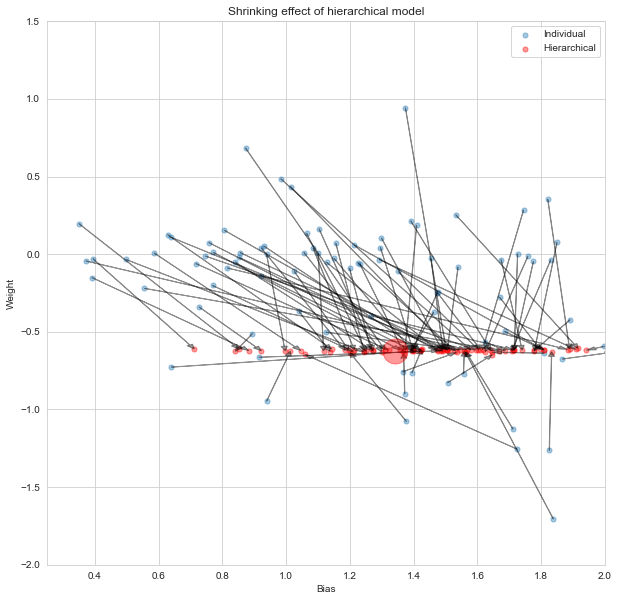

In [11]:
predictive = Predictive(hierarchical_model, guide=guide, num_samples=1000)

with torch.no_grad():
    ppc = predictive(x, county_idx, y)
    
print(ppc.keys())
print(ppc['b'].shape)

b_hier = ppc['b'].mean(axis=0)
w_hier = ppc['w'].mean(axis=0)
b_loc_hier = ppc['b_loc'].mean()
w_loc_hier = ppc['w_loc'].mean()
plot_shrinking(b_indiv, w_indiv, b_hier, w_hier, b_loc_hier, w_loc_hier)

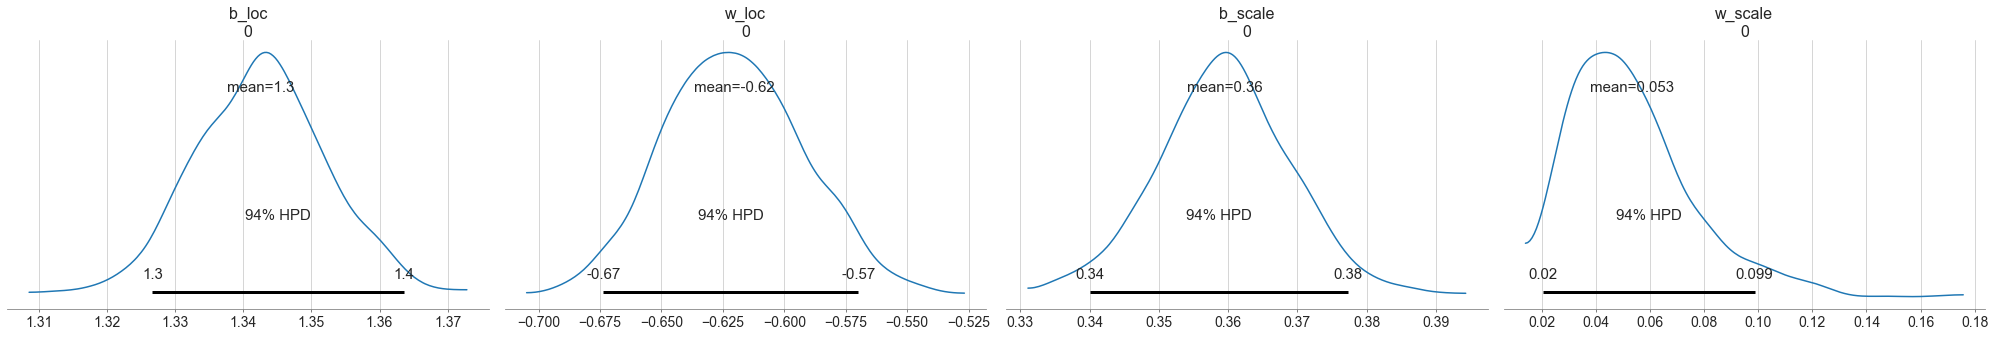

In [12]:
# w_scale is very close to zero
data = az.from_dict({k: np.expand_dims(v.numpy(), 0) 
                     for k, v in ppc.items()})
az.plot_posterior(data, var_names=["b_loc", "w_loc", "b_scale", "w_scale"]);